In [43]:
# Notebook Layout: Kaggle Dataset Analysis & Modeling

## 1. Introduction
- Brief description of the dataset and problem statement

## 2. Data Loading
- Load dataset from repo

## 3. Exploratory Data Analysis (EDA)
- Data overview (shape, columns, types)
- Missing values analysis
- Summary statistics
- Visualizations (histograms, boxplots, correlation heatmap)

## 4. Data Preprocessing
- Handling missing values
- Feature engineering
- Encoding categorical variables
- Train-test split

## 5. Linear Regression
- Model training
- Evaluation (metrics, residual plots)

## 6. Logistic Regression
- Model training (if classification)
- Evaluation (metrics, ROC curve, confusion matrix)

## 7. Generalized Additive Models (GAM)
- Model training
- Evaluation (metrics, plots)

## 8. Model Comparison
- Compare performance metrics across models
- Visual comparison (bar chart of scores)

## 9. Conclusions & Next Steps
- Summary of findings
- Suggestions for further analysis



SyntaxError: invalid syntax. Perhaps you forgot a comma? (3275709931.py, line 4)

In [ ]:
# data loading into data frame and dataprep 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor


df=pd.read_csv("data.csv")

# print(df.describe(include='all'))
# print(df.info())
# print(df.head())
# print(df.nunique())

# checking why total charges is object
# empty_charges = df[df['TotalCharges'].str.contains(' ', na=False, regex=False)]
# if not empty_charges.empty:
#    print("\nRows with empty strings in 'TotalCharges':")
#    print(empty_charges)

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.fillna({'TotalCharges':0} , inplace=True)
# print(df.info())

# preparing data for models
# Separate features (X) and target (y)
X = df.drop(['customerID', 'Churn'], axis=1)
y = df['Churn'].map({'Yes': 1, 'No': 0})

# data split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# encoding categorical data(not using onehot encoder because of numpy to pandas conversion)

# Identify categorical and numerical columns
categorical_cols = X_train.select_dtypes(include=['object']).columns
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

X_train_encoded_categorical = pd.get_dummies(X_train[categorical_cols], drop_first=True)
X_test_encoded_categorical = pd.get_dummies(X_test[categorical_cols], drop_first=True)

X_train_final = pd.concat([X_train[numerical_cols], X_train_encoded_categorical], axis=1)
X_test_final = pd.concat([X_test[numerical_cols], X_test_encoded_categorical], axis=1)

bool_cols = X_train_final.select_dtypes(include='bool').columns
X_train_final[bool_cols] = X_train_final[bool_cols].astype(int)
X_test_final[bool_cols] = X_test_final[bool_cols].astype(int)

# print (X_train_final.info())
# print (X_test_final.info())
# print(y_train.info())



Churn distribution:
Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


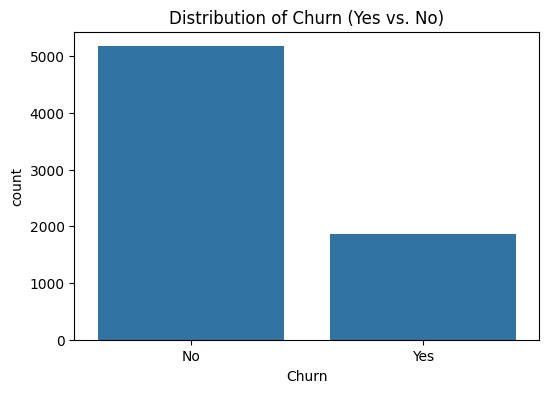

significant class imbalance. Stratifying split and using appropriate class weights


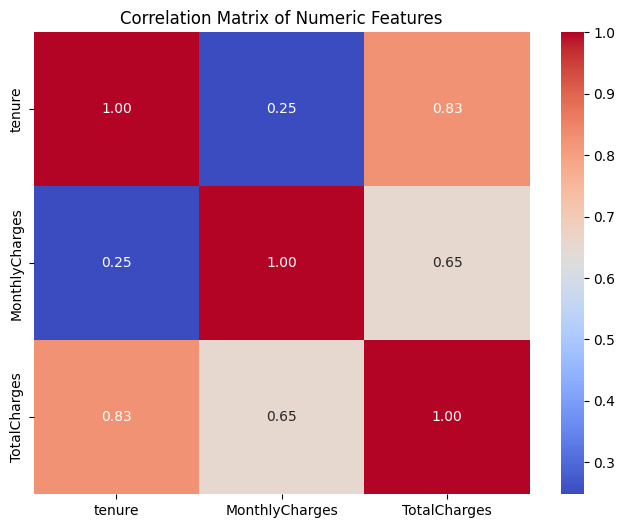

tenure vs. TotalCharges (0.83):  very strong positive correlation
MonthlyCharges vs.TotalCharges (0.65): strong positive correlation
tenure vs. MonthlyCharges (0.25): weak positive correlation
Might have to either remove Total charges or use penalties/regularization(lasso ridge)


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
# Eda and Assumption check

# --- Check for Class Imbalance

print("Churn distribution:")
print(df['Churn'].value_counts(normalize=True))

plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df)
plt.title('Distribution of Churn (Yes vs. No)')
plt.show()

print ("significant class imbalance. Stratifying split and using appropriate class weights")

# ---Check for Multicollinearity ---

numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

plt.figure(figsize=(8, 6))
sns.heatmap(df[numeric_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Numeric Features')
plt.show()

print("tenure vs. TotalCharges (0.83):  very strong positive correlation\nMonthlyCharges vs.TotalCharges (0.65): strong positive correlation\ntenure vs. MonthlyCharges (0.25): weak positive correlation")
print("Might have to either remove Total charges or use penalties/regularization(lasso ridge)")

# VIF score

vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train.columns))]
print(vif_data.sort_values(by='VIF', ascending=False))


# --- Check Relationships & Outliers - Box Plots 
for feature in numeric_cols:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Churn', y=feature, data=df)
    plt.title(f'Churn vs. {feature}')
    plt.xlabel('Churn (0: No, 1: Yes)')
    plt.ylabel(feature)
    plt.show()

print("Tenure:People who have lower tenure are more likely to churn\n Monthly charges:People with slightly higher monthly charges have churned\nTotal charges:Lower Total charges have churned but many outliers in the data")    


# ---- Check Linearity ---

# Note: The goal for categorical features is to compare the churn rate between categories. You don't need to check for a linear relationship.

for feature in numeric_cols:
    plt.figure(figsize=(8, 6))
    sns.regplot(x=feature, y='Churn', data=df, logistic=True, scatter_kws={'alpha': 0.3})
    plt.title(f'Relationship between {feature} and Churn')
    plt.xlabel(feature)
    plt.ylabel('Churn Probability')
    plt.show()
